In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np
from scipy import sparse
from sklearn.metrics import mean_squared_error
from mvlearn.semi_supervised import CTRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from scipy import linalg
from sklearn import preprocessing
from sklearn.model_selection import LeaveOneOut
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

In [2]:
df = pd.read_csv("Data/patient_features_early_stage.csv",sep=",")
Y = df['relapse?'].values
df.drop(['id','relapse?'], inplace=True, axis=1)
print ("Total number of relapsed patient in the data:",np.count_nonzero(Y))
print ("Total number of survived patient in the data:",len(Y)-np.count_nonzero(Y))
print ("Total number of patient:",len(Y))


Total number of relapsed patient in the data: 491
Total number of survived patient in the data: 857
Total number of patient: 1348


In [3]:
new_df_hosp = df[['diagnosis_stage_t', 'diagnosis_stage_n', 'diagnosis_stage_m','gender','race',
                       'age','tumor_stage']]

In [4]:
###In this data we have Aneuploidy score and status_1p we need to take the ID's of the patient from TCGA dataset###
df_tcga_luad_dirk_data_clinical_patient = pd.read_csv("Data/TCGA-LUAD-CLIN-PAN-CAN-2018/data_clinical_patient.txt",sep = "\t",comment='#')
df_tcga_luad_dirk_data_clinical_sample = pd.read_csv("Data/TCGA-LUAD-CLIN-PAN-CAN-2018/data_clinical_sample.txt",sep = "\t",comment='#')
patient_data_tcga = pd.merge(df_tcga_luad_dirk_data_clinical_sample,df_tcga_luad_dirk_data_clinical_patient,on='PATIENT_ID')

In [5]:
df_tcga_luad_dirk_data_clinical_patient.head()

,PATIENT_ID,SUBTYPE,CANCER_TYPE_ACRONYM,OTHER_PATIENT_ID,AGE,SEX,AJCC_PATHOLOGIC_TUMOR_STAGE,AJCC_STAGING_EDITION,DAYS_LAST_FOLLOWUP,DAYS_TO_BIRTH,...,CENTER,IN_PANCANPATHWAYS_FREEZE,OS_STATUS,OS_MONTHS,DSS_STATUS,DSS_MONTHS,DFS_STATUS,DFS_MONTHS,PFS_STATUS,PFS_MONTHS
0,TCGA-05-4244,LUAD,LUAD,34040b83-7e8a-4264-a551-b16621843e28,70.0,Male,STAGE IV,6TH,0.0,-25752.0,...,Indivumed,Yes,LIVING,0.000000,ALIVE OR DEAD TUMOR FREE,0.000000,NaN,NaN,CENSORED,0.000000
1,TCGA-05-4249,LUAD,LUAD,4addf05f-3668-4b3f-a17f-c0227329ca52,67.0,Male,STAGE IB,6TH,1523.0,-24532.0,...,Indivumed,Yes,LIVING,50.070684,ALIVE OR DEAD TUMOR FREE,50.070684,NaN,NaN,CENSORED,50.070684
2,TCGA-05-4250,LUAD,LUAD,f98ecd8a-b878-4f53-b911-20cd8e17281c,79.0,Female,STAGE IIIA,6TH,NaN,-29068.0,...,Indivumed,Yes,DECEASED,3.978039,NaN,3.978039,NaN,NaN,CENSORED,3.978039
3,TCGA-05-4382,LUAD,LUAD,3434b91a-c05f-460f-a078-7b1bb6e7085d,68.0,Male,STAGE IB,6TH,607.0,-24868.0,...,Indivumed,Yes,LIVING,19.955946,ALIVE OR DEAD TUMOR FREE,19.955946,Recurred/Progressed,10.980702,PROGRESSION,10.980702
4,TCGA-05-4384,LUAD,LUAD,9a50e7e4-831d-489f-87d2-979e987561cc,66.0,Male,STAGE IIIA,6TH,426.0,-24411.0,...,Indivumed,Yes,LIVING,14.005326,ALIVE OR DEAD TUMOR FREE,14.005326,NaN,NaN,PROGRESSION,6.016372


In [6]:
# sorted(list(df_tcga_luad_dirk_data_clinical_patient))

In [7]:
# sorted(df_tcga_luad_dirk_data_clinical_patient.columns)

In [8]:
# df_tcga_luad_dirk_data_clinical_patient['DFS_STATUS'].unique()

In [9]:
###In this data we have Pathway score and status_1p###
df_tcga_luad_progeny = pd.read_csv("Data/results_progeny_LUAD.txt",sep = "\t",comment='#')
df_tcga_luad_progeny.shape
# df_tcga_luad_dirk_data_clinical_sample = pd.read_csv("Data/results_progeny_LUSC.txt",sep = "\t",comment='#')
# patient_data_tcga = pd.merge(df_tcga_luad_dirk_data_clinical_sample,df_tcga_luad_dirk_data_clinical_patient,on='PATIENT_ID')

(510, 15)

In [10]:
df_tcga_luad_dirk_data_clinical_sample = pd.read_csv("Data/results_progeny_LUSC.txt",sep = "\t",comment='#')
df_tcga_luad_dirk_data_clinical_sample.head()

,ID,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,p53,PI3K,TGFb,TNFa,Trail,VEGF,WNT
0,TCGA.18.3406.01,134.798037,6.957781,104.006560,561.296151,368.724242,37.736162,941.029609,188.807471,-122.966245,59.227023,875.673497,31.875968,-40.707561,34.557935
1,TCGA.18.3407.01,94.438692,14.721285,-17.290763,245.596729,483.978580,-9.042567,524.553152,108.711681,76.701252,178.542415,541.448009,-18.499366,31.680988,3.833739
2,TCGA.18.3408.01,27.642591,-153.276057,8.451978,55.316242,-705.401354,-136.067443,-374.695391,148.004631,89.957621,-274.833781,-456.007805,21.169080,-107.114664,-48.715896
3,TCGA.18.3410.01,15.551739,-140.987192,-118.040025,-7.079477,111.662063,-160.870262,1097.034274,368.917636,-50.314406,37.039742,850.764509,15.030191,-46.305989,-55.251427
4,TCGA.18.3411.01,-27.880386,71.308636,-27.682529,-242.270221,-489.467192,120.419017,-225.637087,58.129520,-30.465365,-113.737284,-226.644194,43.212077,70.003570,-62.937241


In [11]:
# df_tcga_luad_progeny.head()

In [12]:
df_tcga_luad_progeny["ID"] = [i.replace(".","-") for i in df_tcga_luad_progeny["ID"].values]
df_tcga_luad_progeny["Temp_ID"]= [i.rsplit('-', 1)[0] for i in df_tcga_luad_progeny["ID"].values]
df_tcga_luad_progeny.head()

,ID,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,p53,PI3K,TGFb,TNFa,Trail,VEGF,WNT,Temp_ID
0,TCGA-05-4244-01,20.237317,29.884281,18.568001,347.093586,-119.021245,75.278207,175.306065,82.553795,-90.669812,-125.053208,304.618968,-3.156393,32.338207,-16.041081,TCGA-05-4244
1,TCGA-05-4249-01,42.199917,7.902746,-78.936093,-43.530604,159.674662,38.853723,-154.091824,-21.637581,36.757198,-53.213674,-280.115100,16.447163,58.203644,-47.571033,TCGA-05-4249
2,TCGA-05-4250-01,38.062201,203.262077,52.765835,321.472037,220.475068,326.089502,214.286829,53.301848,56.897325,38.354524,315.833768,9.038467,-39.655358,5.071852,TCGA-05-4250
3,TCGA-05-4382-01,-113.634463,-25.106289,33.520161,654.546935,38.908314,-41.602823,751.319749,-71.551005,-0.029978,289.050690,682.262103,23.337202,-12.287629,56.879479,TCGA-05-4382
4,TCGA-05-4384-01,152.713222,-94.305104,46.615608,-348.754593,-472.086478,-89.693612,-281.310975,272.449847,-43.367426,-90.553003,-291.719332,-8.931036,-93.879876,7.055034,TCGA-05-4384


In [13]:
patient_data_tcga_pathway = pd.merge(df_tcga_luad_progeny,patient_data_tcga,left_on="Temp_ID",right_on="PATIENT_ID")
patient_data_tcga_pathway.head()



,ID,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,p53,PI3K,...,CENTER,IN_PANCANPATHWAYS_FREEZE,OS_STATUS,OS_MONTHS,DSS_STATUS,DSS_MONTHS,DFS_STATUS,DFS_MONTHS,PFS_STATUS,PFS_MONTHS
0,TCGA-05-4244-01,20.237317,29.884281,18.568001,347.093586,-119.021245,75.278207,175.306065,82.553795,-90.669812,...,Indivumed,Yes,LIVING,0.000000,ALIVE OR DEAD TUMOR FREE,0.000000,NaN,NaN,CENSORED,0.000000
1,TCGA-05-4249-01,42.199917,7.902746,-78.936093,-43.530604,159.674662,38.853723,-154.091824,-21.637581,36.757198,...,Indivumed,Yes,LIVING,50.070684,ALIVE OR DEAD TUMOR FREE,50.070684,NaN,NaN,CENSORED,50.070684
2,TCGA-05-4250-01,38.062201,203.262077,52.765835,321.472037,220.475068,326.089502,214.286829,53.301848,56.897325,...,Indivumed,Yes,DECEASED,3.978039,NaN,3.978039,NaN,NaN,CENSORED,3.978039
3,TCGA-05-4382-01,-113.634463,-25.106289,33.520161,654.546935,38.908314,-41.602823,751.319749,-71.551005,-0.029978,...,Indivumed,Yes,LIVING,19.955946,ALIVE OR DEAD TUMOR FREE,19.955946,Recurred/Progressed,10.980702,PROGRESSION,10.980702
4,TCGA-05-4384-01,152.713222,-94.305104,46.615608,-348.754593,-472.086478,-89.693612,-281.310975,272.449847,-43.367426,...,Indivumed,Yes,LIVING,14.005326,ALIVE OR DEAD TUMOR FREE,14.005326,NaN,NaN,PROGRESSION,6.016372


In [14]:
# variable_of_interest = 'Androgen'
variable_of_interest ="EGFR"
# variable_of_interest ="Estrogen"
# variable_of_interest = "p53"
# variable_of_interest = "Hypoxia"
# variable_of_interest = "JAK-STAT"
# variable_of_interest = "MAPK"
# variable_of_interest = "NFkB"
# variable_of_interest = "PI3K"
# variable_of_interest = "TGFb"
# variable_of_interest = "TNFa"
# variable_of_interest = "Trail"
# variable_of_interest = "VEGF"
# variable_of_interest = "WNT"
new_df_tcga = patient_data_tcga_pathway[["SEX","RACE","AGE","AJCC_PATHOLOGIC_TUMOR_STAGE",
                                 "PATH_M_STAGE","PATH_N_STAGE","PATH_T_STAGE",variable_of_interest]]

new_df_tcga.shape


(510, 8)

In [15]:
#new_df_tcga.isnull().sum().sum()

cat_cols = []
non_cat_cols = []
for col in list(new_df_tcga.columns):
    if new_df_tcga[col].dtype == object:
        cat_cols.append(col)
    else:
        non_cat_cols.append(col)
        
# fill empty cells of categorical data
new_df_tcga[cat_cols]=new_df_tcga[cat_cols].fillna("na")
new_df_tcga[non_cat_cols]=new_df_tcga[non_cat_cols].fillna(-1)
new_df_tcga.head()

/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,SEX,RACE,AGE,AJCC_PATHOLOGIC_TUMOR_STAGE,PATH_M_STAGE,PATH_N_STAGE,PATH_T_STAGE,EGFR
0,Male,na,70.0,STAGE IV,M1,N2,T2,29.884281
1,Male,na,67.0,STAGE IB,M0,N0,T2,7.902746
2,Female,na,79.0,STAGE IIIA,M0,N1,T3,203.262077
3,Male,na,68.0,STAGE IB,M0,N0,T2,-25.106289
4,Male,na,66.0,STAGE IIIA,M0,N2,T2,-94.305104


In [16]:
new_df_tcga.isnull().sum().sum()
new_df_tcga["RACE"].unique()

array(['na', 'White', 'Black or African American', 'Asian',
       'American Indian or Alaska Native'], dtype=object)

In [17]:
###Finding the rows which has all the column having null values##
idx = new_df_tcga.isnull().all(1)
nan_tcga = new_df_tcga.loc[idx]
print (nan_tcga.shape)
print (new_df_tcga.shape)
print ("remaining data after clearing all the nan values:",new_df_tcga.shape[0]-nan_tcga.shape[0])

(0, 8)
(510, 8)
remaining data after clearing all the nan values: 510


In [18]:
new_df_tcga_after_nan = new_df_tcga.drop(list(nan_tcga.index),axis=0)
new_df_tcga_after_nan.head()

,SEX,RACE,AGE,AJCC_PATHOLOGIC_TUMOR_STAGE,PATH_M_STAGE,PATH_N_STAGE,PATH_T_STAGE,EGFR
0,Male,na,70.0,STAGE IV,M1,N2,T2,29.884281
1,Male,na,67.0,STAGE IB,M0,N0,T2,7.902746
2,Female,na,79.0,STAGE IIIA,M0,N1,T3,203.262077
3,Male,na,68.0,STAGE IB,M0,N0,T2,-25.106289
4,Male,na,66.0,STAGE IIIA,M0,N2,T2,-94.305104


In [19]:
new_df_tcga_after_nan.isnull().sum().sum()

0

In [20]:
def normalize_tcga_data_same_as_hosp_data():
    new_df_tcga_after_nan.replace(['STAGE IV', 'STAGE IB', 'STAGE IIIA', 'STAGE IA', 'STAGE IIIB','STAGE IIA'], ['IV','IB',
                                  'IIIA','IA','IIIB','IIA'],inplace=True)
    
    new_df_tcga_after_nan['PATH_M_STAGE'] = new_df_tcga_after_nan.PATH_M_STAGE.replace(['M1', 'M0','MX', 'M1B', 'M1A'],
                                                                                        ['M1','M0','Mx','M1b','M1a'])
    
    new_df_tcga_after_nan['PATH_N_STAGE'] = new_df_tcga_after_nan.PATH_N_STAGE.replace(['N2', 'N0', 'N1', 'N3', 'NX'],
                                                                                        ['N2', 'N0', 'N1', 'N3', 'Nx'])
    
    new_df_tcga_after_nan['PATH_T_STAGE'] = new_df_tcga_after_nan.PATH_T_STAGE.replace(['T2', 'T3', 'T1', 'T4', 'T2B','T1B', 'T2A', 'T1A', 'TX'],
                                                                                        ['T2', 'T3', 'T1', 'T4', 'T2b', 'T1b', 'T2a', 'T1a', 'Tx'])
    
    
    new_df_tcga_after_nan['RACE'] = new_df_tcga_after_nan.RACE.replace(['White', 'American Indian or Alaska Native'],'Caucasian')
    
    new_df_tcga_after_nan['RACE'] = new_df_tcga_after_nan.RACE.replace(['Black or African American'],['African'])
    
    return new_df_tcga_after_nan
        


def rename_the_column_name():
    new_df_tcga_after_nan.rename(columns={'SEX': 'gender', 'RACE': 'race','AGE':'age',
                                                                  'AJCC_PATHOLOGIC_TUMOR_STAGE':'tumor_stage',
                                                                
                                                                  'PATH_M_STAGE':'diagnosis_stage_m',
                                                                  'PATH_N_STAGE':'diagnosis_stage_n',
                                                                  'PATH_T_STAGE':'diagnosis_stage_t'},inplace=True)
    
    
    return new_df_tcga_after_nan
    
    

def reorder_the_column_name():
    new_df_tcga_after_nan = new_df_tcga_after_nan[["diagnosis_stage_t","diagnosis_stage_n",
                                                   "diagnosis_stage_m","gender","race",
                                                   "age","tumor_stage","last_recorded_timestamp_months",
                                                   "number_of_radiotherapies",variable_of_interest]]
    
    return new_df_tcga_after_nan
    
new_df_tcga_after_nan = normalize_tcga_data_same_as_hosp_data()
new_df_tcga_after_nan = rename_the_column_name()
new_df_tcga_after_nan = new_df_tcga_after_nan[["diagnosis_stage_t","diagnosis_stage_n",
                                                   "diagnosis_stage_m","gender","race",
                                                   "age","tumor_stage",variable_of_interest]]

###fill the missing values with -1###
new_df_tcga_after_nan = new_df_tcga_after_nan.fillna(-1)
new_df_tcga_after_nan.head()



,diagnosis_stage_t,diagnosis_stage_n,diagnosis_stage_m,gender,race,age,tumor_stage,EGFR
0,T2,N2,M1,Male,na,70.0,IV,29.884281
1,T2,N0,M0,Male,na,67.0,IB,7.902746
2,T3,N1,M0,Female,na,79.0,IIIA,203.262077
3,T2,N0,M0,Male,na,68.0,IB,-25.106289
4,T2,N2,M0,Male,na,66.0,IIIA,-94.305104


Normalizing tumor stage in TCGA datasets

In [21]:
for i in new_df_tcga_after_nan.index:
    if(new_df_tcga_after_nan.at[i,'tumor_stage']== "STAGE IIB"):
        new_df_tcga_after_nan.at[i,'tumor_stage']='IIB'
       
    if(new_df_tcga_after_nan.at[i,'tumor_stage']== "STAGE II"):
        new_df_tcga_after_nan.at[i,'tumor_stage']='II'
       
    if(new_df_tcga_after_nan.at[i,'tumor_stage']== "STAGE I"):
        new_df_tcga_after_nan.at[i,'tumor_stage']='I'

# Dummy coding TNM stages in SLCG and TCGA datasets
This idea is got from the paper: https://pubmed.ncbi.nlm.nih.gov/31911366/ (Table 3)

In [22]:
def tnm_staging_uniformity():
    for i in new_df_tcga_after_nan.index:     
        if (new_df_tcga_after_nan.at[i, "diagnosis_stage_t"]=="T1" or 
            new_df_tcga_after_nan.at[i, "diagnosis_stage_t"]=="T1a" or 
            new_df_tcga_after_nan.at[i, "diagnosis_stage_t"]=="T1b" or 
            new_df_tcga_after_nan.at[i, "diagnosis_stage_t"]=="T1c" or 
            new_df_tcga_after_nan.at[i, "diagnosis_stage_t"]=="T1mi" or 
            new_df_tcga_after_nan.at[i, "diagnosis_stage_t"]=="Tis"):
            new_df_tcga_after_nan.at[i, "diagnosis_stage_t"] = "T1"

        if (new_df_tcga_after_nan.at[i, "diagnosis_stage_t"]=="T2" or 
            new_df_tcga_after_nan.at[i, "diagnosis_stage_t"]=="T2a" or 
            new_df_tcga_after_nan.at[i, "diagnosis_stage_t"]=="T2b"):
            new_df_tcga_after_nan.at[i, "diagnosis_stage_t"] = "T2"


        if (new_df_tcga_after_nan.at[i, "diagnosis_stage_m"]=="M1" or 
            new_df_tcga_after_nan.at[i, "diagnosis_stage_m"]=="M1a" or 
            new_df_tcga_after_nan.at[i, "diagnosis_stage_m"]=="M1b" or 
            new_df_tcga_after_nan.at[i, "diagnosis_stage_m"]=="M1c"):
            new_df_tcga_after_nan.at[i, "diagnosis_stage_m"] = "M1"


    for i in new_df_hosp.index:
        if (new_df_hosp.at[i, "diagnosis_stage_t"]=="T2" or 
            new_df_hosp.at[i, "diagnosis_stage_t"]=="T2a" or 
            new_df_hosp.at[i, "diagnosis_stage_t"]=="T2b"):
            new_df_hosp.at[i, "diagnosis_stage_t"] = "T2"

        if (new_df_hosp.at[i, "diagnosis_stage_t"]=="T1" or 
            new_df_hosp.at[i, "diagnosis_stage_t"]=="T1a" or 
            new_df_hosp.at[i, "diagnosis_stage_t"]=="T1b" or 
            new_df_hosp.at[i, "diagnosis_stage_t"]=="T1c" or 
            new_df_hosp.at[i, "diagnosis_stage_t"]=="T1mi" or 
            new_df_hosp.at[i, "diagnosis_stage_t"]=="Tis"):
            new_df_hosp.at[i, "diagnosis_stage_t"] = "T1"

        if (new_df_hosp.at[i, "diagnosis_stage_m"]=="M1" or
            new_df_hosp.at[i, "diagnosis_stage_m"]=="M1a" or 
            new_df_hosp.at[i, "diagnosis_stage_m"]=="M1b" or 
            new_df_hosp.at[i, "diagnosis_stage_m"]=="M1c"):
            new_df_hosp.at[i, "diagnosis_stage_m"] = "M1"


def tumor_stage_uniformity():
    for i in new_df_tcga_after_nan.index:     
        if (new_df_tcga_after_nan.at[i, "tumor_stage"]=="0"):
            new_df_tcga_after_nan.at[i, "tumor_stage"] = "overall_stage_tumor_0"

        if (new_df_tcga_after_nan.at[i, "tumor_stage"]=="IA" or 
            new_df_tcga_after_nan.at[i, "tumor_stage"]=="I" or
            new_df_tcga_after_nan.at[i,"tumor_stage"]=="IA1" or 
            new_df_tcga_after_nan.at[i, "tumor_stage"]=="IA2" or 
            new_df_tcga_after_nan.at[i, "tumor_stage"]=="IA3" or 
            new_df_tcga_after_nan.at[i, "tumor_stage"]=="IB" ):
            new_df_tcga_after_nan.at[i, "tumor_stage"] = "overall_stage_tumor_1"


        if (new_df_tcga_after_nan.at[i, "tumor_stage"]=="IIA" or 
            new_df_tcga_after_nan.at[i, "tumor_stage"]=="II" or
            new_df_tcga_after_nan.at[i,"tumor_stage"]=="IIB"):
            new_df_tcga_after_nan.at[i, "tumor_stage"] = "overall_stage_tumor_2"

        if (new_df_tcga_after_nan.at[i, "tumor_stage"]=="III" or 
            new_df_tcga_after_nan.at[i,"tumor_stage"]=="IIIA" or 
            new_df_tcga_after_nan.at[i,"tumor_stage"]=="IIIB" or 
            new_df_tcga_after_nan.at[i,"tumor_stage"]=="IIIC"):   
            new_df_tcga_after_nan.at[i, "tumor_stage"] = "overall_stage_tumor_3"

        if (new_df_tcga_after_nan.at[i, "tumor_stage"]=="IV" or 
            new_df_tcga_after_nan.at[i,"tumor_stage"]=="IVA" or 
            new_df_tcga_after_nan.at[i,"tumor_stage"]=="IVB"):
            new_df_tcga_after_nan.at[i, "tumor_stage"] = "overall_stage_tumor_4"

    for i in new_df_hosp.index:
        if (new_df_hosp.at[i, "tumor_stage"]=="0"):
            new_df_hosp.at[i, "tumor_stage"] = "overall_stage_tumor_0"

        if (new_df_hosp.at[i, "tumor_stage"]=="IA" or 
            new_df_hosp.at[i, "tumor_stage"]=="I" or
            new_df_hosp.at[i,"tumor_stage"]=="IA1" or 
            new_df_hosp.at[i, "tumor_stage"]=="IA2" or 
            new_df_hosp.at[i, "tumor_stage"]=="IA3" or
            new_df_hosp.at[i, "tumor_stage"]=="IB"):
            new_df_hosp.at[i, "tumor_stage"] = "overall_stage_tumor_1"


        if (new_df_hosp.at[i, "tumor_stage"]=="IIA" or 
            new_df_hosp.at[i,"tumor_stage"]=="II" or
            new_df_hosp.at[i,"tumor_stage"]=="IIB"):
            new_df_hosp.at[i, "tumor_stage"] = "overall_stage_tumor_2"

        if (new_df_hosp.at[i, "tumor_stage"]=="III" or 
            new_df_hosp.at[i,"tumor_stage"]=="IIIA" or 
            new_df_hosp.at[i,"tumor_stage"]=="IIIB" or 
            new_df_hosp.at[i,"tumor_stage"]=="IIIC"): 
            new_df_hosp.at[i, "tumor_stage"] = "overall_stage_tumor_3"

        if (new_df_hosp.at[i, "tumor_stage"]=="IV" or 
            new_df_hosp.at[i,"tumor_stage"]=="IVA" or
            new_df_hosp.at[i,"tumor_stage"]=="IVB"):
            new_df_hosp.at[i, "tumor_stage"] = "overall_stage_tumor_4"


tnm_staging_uniformity()
tumor_stage_uniformity()   

# Training a machine learning Regression Model to find out which predicts the best Pathway score for the TCGA data##

In [23]:
train_pathway_score = new_df_tcga_after_nan[variable_of_interest].values
train_data_tcga = new_df_tcga_after_nan.drop([variable_of_interest], axis = 1)

In [24]:

scaler = preprocessing.StandardScaler()
##one hot encoding for categorical variable###
train_data_tcga = pd.get_dummies(train_data_tcga, columns=["diagnosis_stage_t","diagnosis_stage_n","diagnosis_stage_m","gender","race","tumor_stage"])
train_data_tcga.head()

,age,diagnosis_stage_t_T1,diagnosis_stage_t_T2,diagnosis_stage_t_T3,diagnosis_stage_t_T4,diagnosis_stage_t_Tx,diagnosis_stage_n_N0,diagnosis_stage_n_N1,diagnosis_stage_n_N2,diagnosis_stage_n_N3,...,gender_Male,race_African,race_Asian,race_Caucasian,race_na,tumor_stage_na,tumor_stage_overall_stage_tumor_1,tumor_stage_overall_stage_tumor_2,tumor_stage_overall_stage_tumor_3,tumor_stage_overall_stage_tumor_4
0,70.0,0,1,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,1
1,67.0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,1,0,1,0,0,0
2,79.0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
3,68.0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,1,0,1,0,0,0
4,66.0,0,1,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0


In [25]:
def linear_regression(X_train, X_test,y_train,ytest):
    model = LinearRegression(n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred, squared=False),mean_absolute_percentage_error(y_test, y_pred),mean_absolute_error(y_test, y_pred)

def dummy_regression(X_train, X_test,y_train,ytest):
    model = DummyRegressor(strategy="mean")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred, squared=False),mean_absolute_percentage_error(y_test, y_pred),mean_absolute_error(y_test, y_pred)
    
def linear_svr(X_train, X_test,y_train,ytest):
    mdl = SVR()  
    param_grid = {'C': [0.01,0.1,1]}
    score = 'neg_mean_squared_error'
    mdl_gscv = GridSearchCV(mdl, param_grid, cv=3, scoring = score,n_jobs=-1)
    mdl_gscv.fit(X_train, y_train)
    model = SVR( C = mdl_gscv.best_params_['C'])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred, squared=False),mean_absolute_percentage_error(y_test, y_pred),mean_absolute_error(y_test, y_pred)

def random_forest_regression(X_train, X_test,y_train,ytest):
    param_grid = {'max_depth': range(3,10), 
                  'max_features': ['auto'], 
                  'n_estimators': [100,200]}
    
    
    score = 'neg_mean_squared_error'
    mdl = RandomForestRegressor(random_state=1)
    mdl_gscv = GridSearchCV(mdl, param_grid, cv=3, scoring = score,n_jobs=-1)
    mdl_gscv.fit(X_train, y_train)
    model =  RandomForestRegressor(
                                max_depth= mdl_gscv.best_params_['max_depth'],
                                n_estimators= mdl_gscv.best_params_['n_estimators'],
                                max_features =  mdl_gscv.best_params_['max_features'],
                                random_state=1)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred, squared=False),mean_absolute_percentage_error(y_test, y_pred),mean_absolute_error(y_test, y_pred)

def gradient_boosting_machine_regression(X_train, X_test,y_train,ytest):
    param_grid = {'max_depth': range(3,10), 
                  'max_features': ['auto'], 
                  'n_estimators': [100,200]}
    
                
    score = 'neg_mean_squared_error'
    mdl = GradientBoostingRegressor(random_state=1)
    mdl_gscv = GridSearchCV(mdl, param_grid, cv=3, scoring = score,n_jobs=-1)
    mdl_gscv.fit(X_train, y_train)
    model =  GradientBoostingRegressor(
                                max_depth= mdl_gscv.best_params_['max_depth'],
                                n_estimators= mdl_gscv.best_params_['n_estimators'],
                                
                                random_state=1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred, squared=False),mean_absolute_percentage_error(y_test, y_pred),mean_absolute_error(y_test, y_pred)

def knn_regression(X_train, X_test,y_train,ytest):
    knn_reg = KNeighborsRegressor(n_jobs = -1)
    param_grid = {'n_neighbors': np.arange(3, 21)}
    score = 'neg_mean_squared_error'
    model = GridSearchCV(knn_reg, param_grid, cv=3, scoring = score,n_jobs=-1)
    model.fit(X_train,y_train)
    #knn =  KNeighborsRegressor(knn_gscv.best_params_['n_neighbors'])
    #knn.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred, squared=False),mean_absolute_percentage_error(y_test, y_pred),mean_absolute_error(y_test, y_pred)

def bayesian_regression(X_train, X_test,y_train,ytest):
    model = BayesianRidge()
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred, squared=False),mean_absolute_percentage_error(y_test, y_pred),mean_absolute_error(y_test, y_pred)


def neural_nets_regression(X_train, X_test,y_train,ytest):
    neur_regr = MLPRegressor(random_state=1,shuffle=True)
    X_train = preprocessing.scale(X_train)
    X_test =  preprocessing.scale(X_test)
    
    tuned_parameters = [{'hidden_layer_sizes': [2,4,6,8,10,20,30,40],
                       'activation': ['relu'],
                       'solver':['adam'], 'alpha':[0.0001],
                       'batch_size':['auto'], 'learning_rate':['constant'],
                       'learning_rate_init':[0.001], 'max_iter':[500]}]
    

    model = GridSearchCV(MLPRegressor(), tuned_parameters, cv=3,n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred, squared=False),mean_absolute_percentage_error(y_test, y_pred),mean_absolute_error(y_test, y_pred)


list_of_regression_models = [linear_regression,bayesian_regression,dummy_regression,linear_svr, random_forest_regression,gradient_boosting_machine_regression, knn_regression, neural_nets_regression]
                             
FOLDS = 10
kf = KFold(n_splits=FOLDS)
X = train_data_tcga.values
y = train_pathway_score
model_rmse_matrix = np.zeros((len(list_of_regression_models),FOLDS))
mean_rmse = []
error = []

model_mape_matrix = np.zeros((len(list_of_regression_models),FOLDS))
mean_mape = []
error_mape = []

model_mae_matrix = np.zeros((len(list_of_regression_models),FOLDS))
mean_mae = []
error_mae = []
i = 0
for models in list_of_regression_models:
    score = np.zeros(FOLDS)
    mape = np.zeros(FOLDS)
    mae = np.zeros(FOLDS)
    cnt = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
#         y_test = np.where(y_test==0,0.01,y_test)
        score[cnt],mape[cnt],mae[cnt] = models(X_train, X_test,y_train,y_test)
        cnt+=1
        
    mean_rmse.append(np.mean(score))
    error.append(np.std(score))
    model_rmse_matrix[i,:]= score
    
    mean_mape.append(np.mean(mape))
    error_mape.append(np.std(mape))
    model_mape_matrix[i,:]= mape
    mean_mae.append(np.mean(mae))
    error_mae.append(np.std(mae))
    model_mae_matrix[i,:]= mae
    
    
    i+=1
    print (models.__name__,"Mean RMSE:",np.around(np.mean(score),decimals=3),"Std RMSE:",np.around(np.std(score),decimals=3),"Mean MAPE:",np.around(np.mean(mape),decimals =3),"Std MAPE:",np.around(np.std(mape),decimals=3),"Mean MAE:",np.around(np.mean(mae),decimals=3),"Std MAE:",np.around(np.std(mae),decimals=3))
        
    

linear_regression Mean RMSE: 82.13 Std RMSE: 8.545 Mean MAPE: 1.887 Std MAPE: 0.715 Mean MAE: 65.004 Std MAE: 7.741
bayesian_regression Mean RMSE: 80.963 Std RMSE: 8.011 Mean MAPE: 1.062 Std MAPE: 0.093 Mean MAE: 64.622 Std MAE: 7.284
dummy_regression Mean RMSE: 80.956 Std RMSE: 8.006 Mean MAPE: 1.064 Std MAPE: 0.094 Mean MAE: 64.624 Std MAE: 7.284
linear_svr Mean RMSE: 80.925 Std RMSE: 7.94 Mean MAPE: 1.079 Std MAPE: 0.175 Mean MAE: 64.646 Std MAE: 7.231
random_forest_regression Mean RMSE: 80.504 Std RMSE: 8.551 Mean MAPE: 1.63 Std MAPE: 0.722 Mean MAE: 63.75 Std MAE: 7.649
gradient_boosting_machine_regression Mean RMSE: 85.719 Std RMSE: 9.11 Mean MAPE: 2.284 Std MAPE: 0.949 Mean MAE: 67.6 Std MAE: 7.331
knn_regression Mean RMSE: 82.152 Std RMSE: 7.189 Mean MAPE: 1.876 Std MAPE: 0.813 Mean MAE: 65.83 Std MAE: 6.663


/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  Conv

neural_nets_regression Mean RMSE: 80.456 Std RMSE: 7.89 Mean MAPE: 1.547 Std MAPE: 0.661 Mean MAE: 63.613 Std MAE: 7.047


/home/mohan/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [26]:
index = [i.__name__ .upper() for i in list_of_regression_models]

plotdata_new = pd.DataFrame(
    {
        "RMSE": mean_rmse,
        "MAPE":mean_mape,
        "MAE":mean_mae},
         index=index
     )

plotdata_new

,RMSE,MAPE,MAE
LINEAR_REGRESSION,82.130078,1.886729,65.003915
BAYESIAN_REGRESSION,80.963208,1.062092,64.621804
DUMMY_REGRESSION,80.955916,1.064434,64.623539
LINEAR_SVR,80.924942,1.079401,64.645552
RANDOM_FOREST_REGRESSION,80.503887,1.630054,63.750392
GRADIENT_BOOSTING_MACHINE_REGRESSION,85.718746,2.283534,67.599933
KNN_REGRESSION,82.151884,1.875906,65.829740
NEURAL_NETS_REGRESSION,80.456390,1.547203,63.613363


<Figure size 432x288 with 0 Axes>

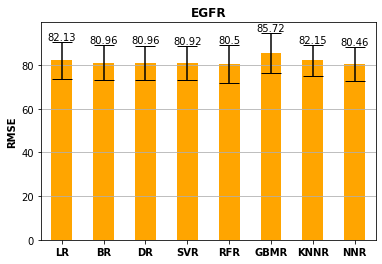

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
f = plt.figure()
##.__name__  gives the function name very handy function##

index = [i.__name__ .upper() for i in list_of_regression_models]
#print (index)
plotdata = pd.DataFrame(
    {"RMSE": mean_rmse}, 
    index=index)

#Plot a bar chart
plotdata.plot(kind="bar",legend=False,color = "orange",yerr=error,align='center', 
              alpha=1.0, ecolor='black', capsize=10)
plt.title(variable_of_interest,weight = 'bold')

plt.xticks(rotation=0, horizontalalignment="center",weight = 'bold')
plt.xticks(np.arange(len(plotdata.index)), ['LR', 'BR','DR','SVR','RFR','GBMR','KNNR','NNR'])
#plt.ylim(0,1)
plt.ylabel("RMSE",weight = 'bold')
plt.grid(axis ="y")

for i in range(len(plotdata.index)):
    plt.text(i,mean_rmse[i]+error[i],np.around(mean_rmse[i],decimals=2),ha="center",va="bottom")

# plt.savefig('performance_aneuploidy_prediction.eps',bbox_inches='tight')

In [28]:
from scipy.stats import wilcoxon

alpha = 0.05
best_rmse = list(plotdata_new[['RMSE']].idxmin())[0]
indexes = list(plotdata.index)
print("Best score is given by:",best_rmse)
choice_index = indexes.index(best_rmse)
print("Choice Index of the best RMSE:",choice_index)
for i in range(model_rmse_matrix.shape[0]):
    if i!=choice_index:
        stat, p = wilcoxon(model_rmse_matrix[choice_index,:], model_rmse_matrix[i,:])
        if p > alpha:
            print('Same distribution (fail to reject H0)=>',list_of_regression_models[choice_index].__name__,":",
                  list_of_regression_models[i].__name__,p)
        else:
            print('Different distribution (reject H0)=>',list_of_regression_models[choice_index].__name__,":",
                  list_of_regression_models[i].__name__,p)
    

Best score is given by: NEURAL_NETS_REGRESSION
Choice Index of the best RMSE: 7
Same distribution (fail to reject H0)=> neural_nets_regression : linear_regression 0.322265625
Same distribution (fail to reject H0)=> neural_nets_regression : bayesian_regression 0.232421875
Same distribution (fail to reject H0)=> neural_nets_regression : dummy_regression 0.232421875
Same distribution (fail to reject H0)=> neural_nets_regression : linear_svr 0.275390625
Same distribution (fail to reject H0)=> neural_nets_regression : random_forest_regression 0.845703125
Different distribution (reject H0)=> neural_nets_regression : gradient_boosting_machine_regression 0.005859375
Different distribution (reject H0)=> neural_nets_regression : knn_regression 0.01953125


<Figure size 432x288 with 0 Axes>

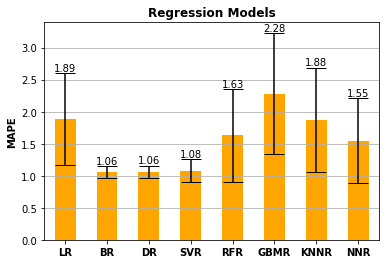

In [29]:
%matplotlib inline
f = plt.figure()
##.__name__  gives the function name very handy function##

index = [i.__name__ .upper() for i in list_of_regression_models]
#print (index)
plotdata = pd.DataFrame(
    {"MAPE": mean_mape}, 
    index=index)

#Plot a bar chart
plotdata.plot(kind="bar",legend=False,color = "orange",yerr=error_mape,align='center', 
              alpha=1.0, ecolor='black', capsize=10)
plt.title("Regression Models",weight = 'bold')

plt.xticks(rotation=0, horizontalalignment="center",weight = 'bold')
plt.xticks(np.arange(len(plotdata.index)), ['LR', 'BR','DR','SVR','RFR','GBMR','KNNR','NNR'])
#plt.ylim(0,1)
plt.ylabel("MAPE",weight = 'bold')
plt.grid(axis ="y")

for i in range(len(plotdata.index)):
    plt.text(i,mean_mape[i]+error_mape[i],np.around(mean_mape[i],decimals=2),ha="center",va="bottom")

# plt.savefig('performance_aneuploi

In [30]:
print("Statistical Test for the best model using MAPE")

from scipy.stats import wilcoxon
alpha = 0.05
best = list(plotdata_new[['MAPE']].idxmin())[0]
indexes = list(plotdata_new.index)
print("Best score is given by:",best)
choice_index = indexes.index(best)
print("Choice Index of the best MAPE:",choice_index)
for i in range(model_mape_matrix.shape[0]):
    if i!=choice_index:
        stat, p = wilcoxon(model_mape_matrix[choice_index,:], model_mape_matrix[i,:])
        if p > alpha:
            print('Same distribution (fail to reject H0)=>',list_of_regression_models[choice_index].__name__,":",
                  list_of_regression_models[i].__name__,p)
        else:
            print('Different distribution (reject H0)=>',list_of_regression_models[choice_index].__name__,":",
                  list_of_regression_models[i].__name__,p)
    

Statistical Test for the best model using MAPE
Best score is given by: BAYESIAN_REGRESSION
Choice Index of the best MAPE: 1
Different distribution (reject H0)=> bayesian_regression : linear_regression 0.001953125
Same distribution (fail to reject H0)=> bayesian_regression : dummy_regression 0.16015625
Same distribution (fail to reject H0)=> bayesian_regression : linear_svr 0.76953125
Different distribution (reject H0)=> bayesian_regression : random_forest_regression 0.013671875
Different distribution (reject H0)=> bayesian_regression : gradient_boosting_machine_regression 0.001953125
Different distribution (reject H0)=> bayesian_regression : knn_regression 0.001953125
Different distribution (reject H0)=> bayesian_regression : neural_nets_regression 0.001953125


<Figure size 432x288 with 0 Axes>

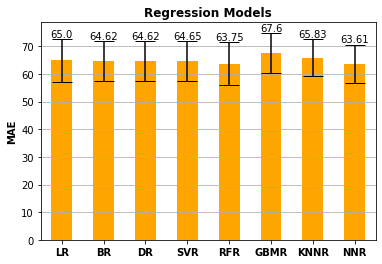

In [31]:
%matplotlib inline
f = plt.figure()
##.__name__  gives the function name very handy function##

index = [i.__name__ .upper() for i in list_of_regression_models]
#print (index)
plotdata = pd.DataFrame(
    {"MAE": mean_mae}, 
    index=index)

#Plot a bar chart
plotdata.plot(kind="bar",legend=False,color = "orange",yerr=error_mae,align='center', 
              alpha=1.0, ecolor='black', capsize=10)
plt.title("Regression Models",weight = 'bold')

plt.xticks(rotation=0, horizontalalignment="center",weight = 'bold')
plt.xticks(np.arange(len(plotdata.index)), ['LR', 'BR','DR','SVR','RFR','GBMR','KNNR','NNR'])
#plt.ylim(0,1)
plt.ylabel("MAE",weight = 'bold')
plt.grid(axis ="y")

for i in range(len(plotdata.index)):
    plt.text(i,mean_mae[i]+error_mae[i],np.around(mean_mae[i],decimals=2),ha="center",va="bottom")


In [32]:
print("Statistical Test for the best model using MAE")

from scipy.stats import wilcoxon
alpha = 0.05
best = list(plotdata_new[['MAE']].idxmin())[0]
indexes = list(plotdata.index)
print("Best score is given by:",best)
choice_index = indexes.index(best)
print("Choice Index of the best MAE:",choice_index)
for i in range(model_mae_matrix.shape[0]):
    if i!=choice_index:
        stat, p = wilcoxon(model_mae_matrix[choice_index,:], model_mae_matrix[i,:])
        if p > alpha:
            print('Same distribution (fail to reject H0)=>',list_of_regression_models[choice_index].__name__,":",
                  list_of_regression_models[i].__name__,p)
        else:
            print('Different distribution (reject H0)=>',list_of_regression_models[choice_index].__name__,":",
                  list_of_regression_models[i].__name__,p)
    

Statistical Test for the best model using MAE
Best score is given by: NEURAL_NETS_REGRESSION
Choice Index of the best MAE: 7
Same distribution (fail to reject H0)=> neural_nets_regression : linear_regression 0.232421875
Same distribution (fail to reject H0)=> neural_nets_regression : bayesian_regression 0.083984375
Same distribution (fail to reject H0)=> neural_nets_regression : dummy_regression 0.083984375
Same distribution (fail to reject H0)=> neural_nets_regression : linear_svr 0.10546875
Same distribution (fail to reject H0)=> neural_nets_regression : random_forest_regression 0.845703125
Different distribution (reject H0)=> neural_nets_regression : gradient_boosting_machine_regression 0.00390625
Different distribution (reject H0)=> neural_nets_regression : knn_regression 0.001953125
